# Implementation of Google Net from Scratch on CIFAR 10 Dataset

In this notebook, I am going to implement a very interesting architecture known as GoogleNet which uses a specific kind of modules known as inception modules which took its name from Leonardo Di Caprios movie Inception. Now I am not gonna explain it theoretically but I am going to explain at every step how to implement.

# Implementing a convolution block
The inception module uses a specific setting of operations or basic layers on CNN again and again in every inception module so we dont wanna implement them again and again so we are defining a class for that block of layers or operations so we can instantiate the object of class whenever we need them. Those layers are:

**1)** A Convolution Layer

**2)** A Batch Normalization Layer

**3)** Lastly a ReLU activation function

In [1]:
import torch
import torch.nn as nn

In [2]:
class convolutionBlock(nn.Module):

    # Constructor of the block taking no of input channels, output channels, kernel size, stride and padding.
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(convolutionBlock, self).__init__()
        
        # Declaration of three layers as I explained that every convolutional block of inception module requires.
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    # Defining how the forward pass will work in an object of this class.     
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

#Implementing an Inception Module
An inception module has four branches. So those four branches are as follows:

**1)** A 1x1 Convolutional layer

**2)** a 1x1 Convolutional layer followed by a 3x3 Convolutional layer

**3)** A 1x1 convolutional layer followed by a 5x5 Convolutional layer

**4)** A maxpool layer followed by a 1x1 Convolutional layer.

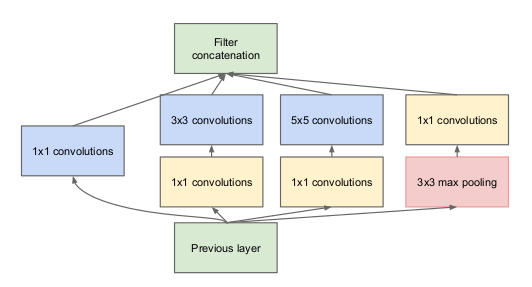

So basically the essense of inception is an inception module. The reason of that is 1x1 convolutional layer reduces the number of channels for 3x3 and 5x5 convolutional layers and hence decreasing the number of multiplications required to perform reduces by 10 factors. Moreover 1x1 layers also successfully extract depth features whereas 3x3 and 5x5 convolutional layers extract the spatial features and hence all the branches of inception module after extracting their respective features are concatenated at the end. This is the reason that GoogleNet enjoys the low computation benefits along with better visual representation of features. 

In [3]:
class InceptionModule(nn.Module):

    # Constructor of an inception module getting input channels coming from previous inception module and output channels for each branch.
    def __init__(self, in_channels, only_1x1_out, k1x1_3_out, k3x3_out, k1x1_5_out, k5x5_out, max_conv_out):
        super(InceptionModule, self).__init__()
        
        # First branch as explained above
        self.bh1 = nn.Sequential(
            convolutionBlock(in_channels, only_1x1_out, kernel_size=1, stride=1, padding=0)
        )
        
        # Second branch as explained above
        self.bh2 = nn.Sequential(
            convolutionBlock(in_channels, k1x1_3_out, kernel_size=1, stride=1, padding=0),
            convolutionBlock(k1x1_3_out, k3x3_out, kernel_size=3, stride=1, padding=1)
        )
        
        # Third branch as explained above
        self.bh3 = nn.Sequential(
            convolutionBlock(in_channels, k1x1_5_out, kernel_size=1, stride=1, padding=0),
            convolutionBlock(k1x1_5_out, k5x5_out, kernel_size=5, stride=1, padding=2)
        )
        
        # Fourth branch as explained above
        self.bh4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            convolutionBlock(in_channels, max_conv_out, kernel_size=1, stride=1, padding=0)
        )


    # Forward pass for inception module branches.    
    def forward(self, x):
        bh1 = self.bh1(x)
        bh2 = self.bh2(x)
        bh3 = self.bh3(x)
        bh4 = self.bh4(x)
        
        # concatenating all the branches output features
        return torch.cat([bh1, bh2, bh3, bh4], 1)

# Implemeting of Auxillary Classifier Class
Basically deeper neural networks suffer from famous "Vanishing Gradient" problem and as the GoogleNet is 22 Layers deep so Vanishing Gradient was a concern in this architecture too. So the architecture was introduced by auxillary classifiers by the original researchers of the architecture. What they did was actually did multiple stage classification and during training they added the loss of these multistaged classification too with the last classifiers loss and hence the vanishing gradient problem now cannot actually take place.

Now as there are multiple auxillary classifiers so its better to make a seperate class for it too. An auxillary classifiers have following layers as defined by the official paper of GoogleNet:

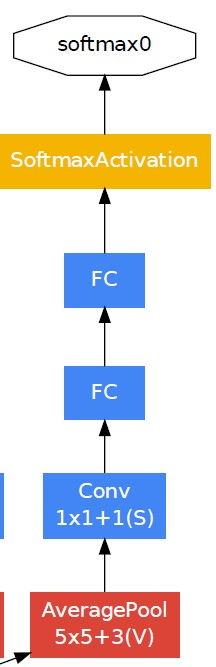

**1)** An Average Pool Layer

**2)** A 1x1 Convolutional Layer

**3)** Two Fully Connected Layers

**4)** Softmax Activation Layer

In [4]:
class AuxillaryClassifier(nn.Module):
    
    # Constructor of Auxillary classifier getting input channels and output no of classes.
    def __init__(self, in_channels, num_classes):
        super(AuxillaryClassifier, self).__init__()
        
        # Defining layers of Auxillary classifier as explained above
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    # Forward pass of auxillary classifier
    def forward(self, x):
        x = self.pool(x)
        
        x = self.conv(x)
        x = self.act(x)
    
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

#Implementing GoogleNet
Now its time to assemble all the parts that we defined earlier and define a class of GoogleNet that gives us our complete model ready to train. I cant explain each layer but I am sharing the official papers screenshot of layers detail from which we are going to implement:

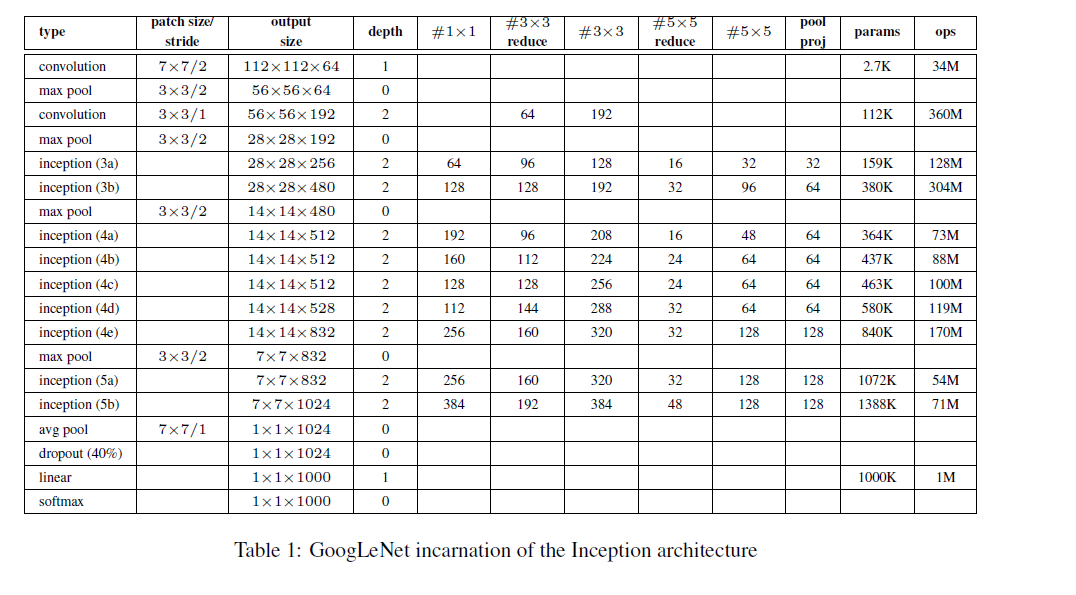

In [5]:
class GoogLeNet(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(GoogLeNet, self).__init__()
      
        self.conv1 = convolutionBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = convolutionBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = convolutionBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = InceptionModule(in_channels=192,
                                           only_1x1_out=64,
                                           k1x1_3_out=96,
                                           k3x3_out=128,
                                           k1x1_5_out=16,
                                           k5x5_out=32,
                                           max_conv_out=32)
        self.inception3B = InceptionModule(in_channels=256,
                                           only_1x1_out=128,
                                           k1x1_3_out=128,
                                           k3x3_out=192,
                                           k1x1_5_out=32,
                                           k5x5_out=96,
                                           max_conv_out=64)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception4A = InceptionModule(in_channels=480,
                                           only_1x1_out=192,
                                           k1x1_3_out=96,
                                           k3x3_out=208,
                                           k1x1_5_out=16,
                                           k5x5_out=48,
                                           max_conv_out=64)
        self.inception4B = InceptionModule(in_channels=512,
                                           only_1x1_out=160,
                                           k1x1_3_out=112,
                                           k3x3_out=224,
                                           k1x1_5_out=24,
                                           k5x5_out=64,
                                           max_conv_out=64)
        self.inception4C = InceptionModule(in_channels=512,
                                           only_1x1_out=128,
                                           k1x1_3_out=128,
                                           k3x3_out=256,
                                           k1x1_5_out=24,
                                           k5x5_out=64,
                                           max_conv_out=64)
        self.inception4D = InceptionModule(in_channels=512,
                                           only_1x1_out=112,
                                           k1x1_3_out=144,
                                           k3x3_out=288,
                                           k1x1_5_out=32,
                                           k5x5_out=64,
                                           max_conv_out=64)
        self.inception4E = InceptionModule(in_channels=528,
                                           only_1x1_out=256,
                                           k1x1_3_out=160,
                                           k3x3_out=320,
                                           k1x1_5_out=32,
                                           k5x5_out=128,
                                           max_conv_out=128)
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception5A = InceptionModule(in_channels=832,
                                           only_1x1_out=256,
                                           k1x1_3_out=160,
                                           k3x3_out=320,
                                           k1x1_5_out=32,
                                           k5x5_out=128,
                                           max_conv_out=128)
        self.inception5B = InceptionModule(in_channels=832,
                                           only_1x1_out=384,
                                           k1x1_3_out=192,
                                           k3x3_out=384,
                                           k1x1_5_out=48,
                                           k5x5_out=128,
                                           max_conv_out=128)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
        self.aux4A = AuxillaryClassifier(512, num_classes) 
        self.aux4D = AuxillaryClassifier(528, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.inception3A(x)
        x = self.inception3B(x)
        x = self.pool4(x)
        x = self.inception4A(x)
  
        aux1 = self.aux4A(x)
        
        x = self.inception4B(x)
        x = self.inception4C(x)
        x = self.inception4D(x)
  
        aux2 = self.aux4D(x)
        
        x = self.inception4E(x)
        x = self.pool5(x)
        x = self.inception5A(x)
        x = self.inception5B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x, aux1, aux2

In [6]:
model = GoogLeNet()

In [7]:
model

GoogLeNet(
  (conv1): convolutionBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): convolutionBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv3): convolutionBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3A): InceptionModule(
    (bh1): Sequential(
      (0): convolutionBlock(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2

#Training the GoogleNet on CIFAR 10 Dataset

## Data Preparation of CIFAR 10 Dataset

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
transform = transforms.Compose([
     transforms.RandomHorizontalFlip(p = 0.5),
     transforms.Resize(224),
     transforms.ToTensor(),
    ])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


##Visualizing one Image from CIFAR 10 Train DataLoader

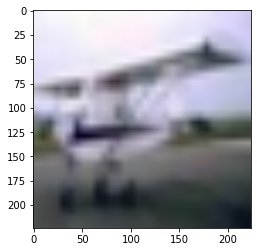

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(images[1])

##Inferencing Before Training From Model for checking Initial Accuracy

In [34]:
model = model.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network

        images = images

        prediction, _, _ = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(prediction.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("Correct: ", correct)
print("Total: ", total)


Accuracy of the network on the 10000 test images: 10 %
Correct:  1089
Total:  10000


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
cd "/content/drive/MyDrive/projects/Practice"

/content/drive/MyDrive/projects/Practice


In [15]:
!ls

GoogleNet  ImageNet  ResNet  VGG16


In [24]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, weight_decay=0.0005, lr=0.00001)

In [25]:
PATH = "./GoogleNet"

num_epoch = 10

model = model.to(device)

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs1, outputs2, outputs3 = model(inputs)
        outputs = outputs1 + outputs2 + outputs3
        
        loss = criterion(outputs, labels)
        # print(loss)
        loss.backward()
        # print("I am here")
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    if (epoch % 1) == 0:
        torch.save(model.state_dict(), (PATH+str(epoch)+".pth"))
        print("saved")

print('Finished Training')

[1,   100] loss: 0.359
[1,   200] loss: 0.362
[1,   300] loss: 0.371
[1,   400] loss: 0.396
[1,   500] loss: 0.368
[1,   600] loss: 0.387
[1,   700] loss: 0.403
[1,   800] loss: 0.364
[1,   900] loss: 0.381
[1,  1000] loss: 0.369
[1,  1100] loss: 0.403
[1,  1200] loss: 0.385
[1,  1300] loss: 0.409
[1,  1400] loss: 0.369
[1,  1500] loss: 0.381
saved
[2,   100] loss: 0.374
[2,   200] loss: 0.385
[2,   300] loss: 0.384
[2,   400] loss: 0.401
[2,   500] loss: 0.380
[2,   600] loss: 0.386
[2,   700] loss: 0.384
[2,   800] loss: 0.390
[2,   900] loss: 0.374
[2,  1000] loss: 0.388
[2,  1100] loss: 0.366
[2,  1200] loss: 0.372
[2,  1300] loss: 0.387
[2,  1400] loss: 0.368
[2,  1500] loss: 0.394
saved
[3,   100] loss: 0.395
[3,   200] loss: 0.391
[3,   300] loss: 0.363
[3,   400] loss: 0.380
[3,   500] loss: 0.361
[3,   600] loss: 0.418
[3,   700] loss: 0.356
[3,   800] loss: 0.389
[3,   900] loss: 0.335
[3,  1000] loss: 0.394
[3,  1100] loss: 0.377
[3,  1200] loss: 0.372
[3,  1300] loss: 0.370

KeyboardInterrupt: ignored

#Inferencing From Trained Model

In [38]:
cd "./GoogleNet"

/content/drive/My Drive/projects/Practice/GoogleNet


In [39]:
!ls

GoogleNet0.pth	GoogleNet1.pth	GoogleNet2.pth


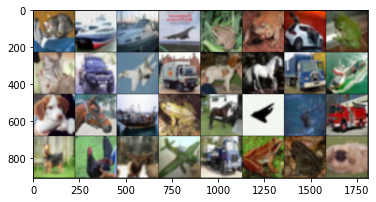

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))


In [41]:
PATH = "./GoogleNet2.pth"

net = GoogLeNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [47]:
outputs,_,_ = net(images)


In [48]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs,_,_ = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [51]:
print("Correct: ", correct)
print("Total: ", total)

Correct:  8029
Total:  10000
